### Time-Series Forecasting

Time-series data consists of data points collected sequentially at regular intervals over a specific period. A time series is termed stationary when its statistical properties, such as mean and

 variance, remain constant over time. These datasets often exhibit autocorrelation, meaning there is a linear relationship between current observations and their past (lagged) values. 

Consequently, historical data can be modeled to forecast future trends without the need for external independent variables. This methodology is known as time-series forecasting. Key application 

areas include sales forecasting, economic trend analysis, and financial market modeling. 


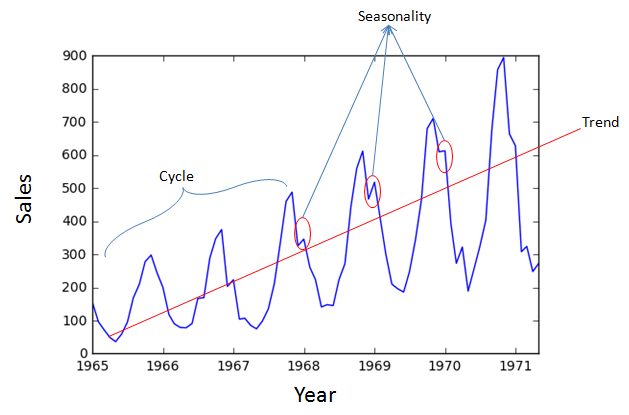

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
Image(filename='../Chapter 3 Figures/Time_Series.png', width=500)

### Autoregressive Integrated Moving Average (ARIMA)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_squared_error

Let's predict sales data using ARIMA

In [3]:
# Data Source: O.D. Anderson (1976), in file: data/anderson14, Description: Monthly sales of company X Jan ’65 – May ’71 C. Cahtfield        
df = pd.read_csv('Data/TS.csv')
ts = pd.Series(list(df['Sales']), index=pd.to_datetime(df['Month'],format='%Y-%m'))

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title('Time Series - Decomposed')
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()

### Checking for stationarity

Let's split the data into train and test. Since its a time series let's consider 1965 to 1968 for training and reamining for testing. 

Business forecasting edition by Hanke and Wichern recommend a minimum of 4 years of data depending on the regularity of data. If the seasonal pattern is regular 3 year data would be sufficient. 

### Remove stationarity

In [5]:
# log transform to remove variability
ts_log = np.log(ts)
ts_log.dropna(inplace=True)

s_test = adfuller(ts_log, autolag='AIC')
print ("Log transform stationary check p value: ", s_test[1])

Log transform stationary check p value:  0.7853102124849102


In [6]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

s_test = adfuller(ts_log_diff, autolag='AIC')
print("First order difference stationary check p value: ", s_test[1])

First order difference stationary check p value:  0.02402539283987548


In [7]:
# moving average smoothens the line
moving_avg = ts_log.rolling(window=2).mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
ax1.set_title('First order difference')
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
ax1.plot(ts_log_diff)

ax2.plot(ts_log)
ax2.set_title('Log vs Moving AVg')
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.plot(moving_avg, color='red')
plt.tight_layout()

### Autocorrelation test

We determined that the log of time series requires at least one order differening to stationarize. Now lets plot ACV and PACF charts for first order log series

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))

# ACF chart
fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=20, ax=ax1)

# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')

# PACF chart
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=20, ax=ax2)

# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

Text(0.5, 0, 'Lags')

PACF plot has a significant spike only at lag 1, meaning that all the higher-order autocorrelations are effectively explained by the lag-1 and lag-2 autocorrelation.

p = 2 i.e., the lag value where the PACF chart crosses the upper confidence interval for the first time

q = 2 i.e., the lag value where the ACF chart crosses the upper confidence interval for the first time

In [9]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = sm.tsa.ARIMA(ts_log, order=(2, 0, 2))
results_ARIMA = model.fit() 

ts_predict = results_ARIMA.predict()

print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)

print("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values)))

print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

AIC:  7.852110626583622
BIC:  21.91494315770573
Mean Absolute Error:  0.1959652611210588
Root Mean Squared Error:  0.23979207706916877
Durbin-Watson statistic : 1.8645734349435032


c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Usual practice is to build several models with different p and q and select the one with smallest value of AIC, BIC, MAE and RMSE. 

Now lets' increase p to 3 and see if there is any difference in result.

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


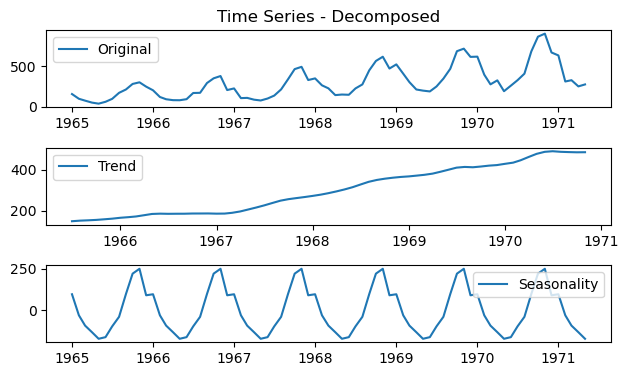

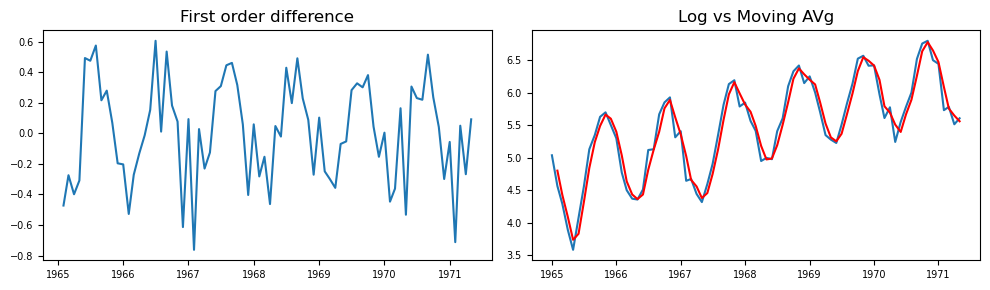

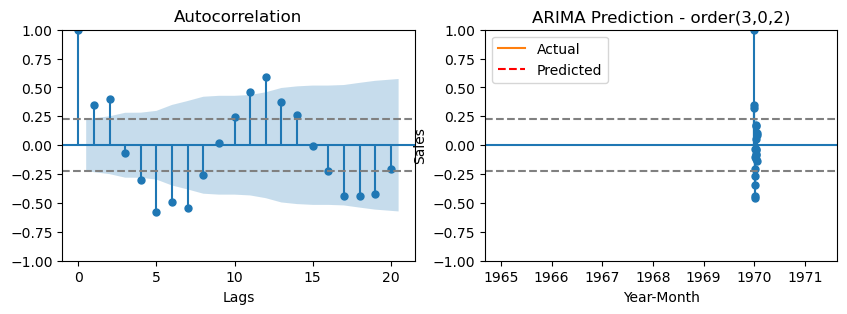

AIC:  9.693491754121121
BIC:  26.10012970709691
Mean Absolute Error:  0.19849817866670555
Root Mean Squared Error:  0.2395759356449222
Durbin-Watson statistic : 1.8243277455413818


In [10]:
model = sm.tsa.ARIMA(ts_log, order=(3, 0, 2))
results_ARIMA = model.fit()

ts_predict = results_ARIMA.predict()
plt.title('ARIMA Prediction - order(3,0,2)')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.show()

print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)

print("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values)))

print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

### Let's try with one level differencing

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


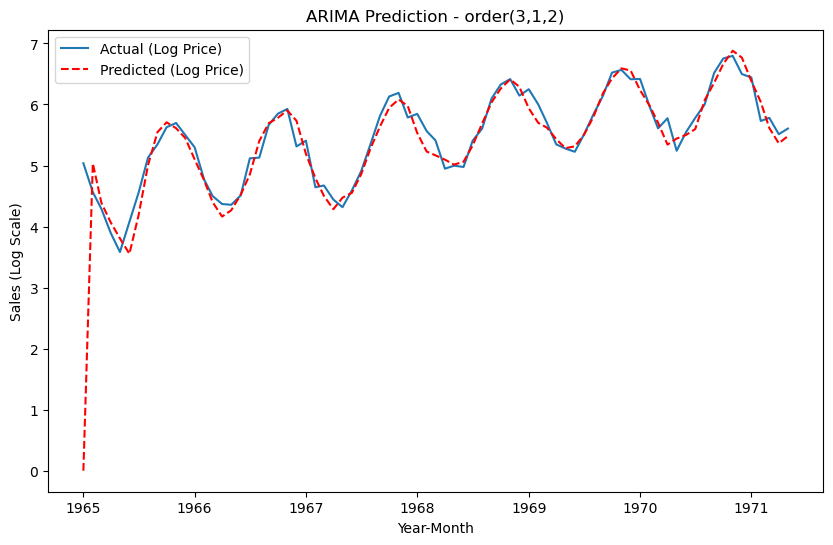

AIC:  -33.21456011983457
BIC:  -19.230160078116587
Mean Absolute Error:  0.21083639135152046
Root Mean Squared Error:  0.6033803304318298
Durbin-Watson statistic : 1.2615061290257505


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = sm.tsa.ARIMA(ts_log, order=(3, 1, 2))
results_ARIMA = model.fit()

ts_predict = results_ARIMA.predict()

plt.figure(figsize=(10, 6))
plt.title('ARIMA Prediction - order(3,1,2)')
plt.plot(ts_log, label='Actual (Log Price)')
plt.plot(ts_predict, 'r--', label='Predicted (Log Price)')
plt.xlabel('Year-Month')
plt.ylabel('Sales (Log Scale)')
plt.legend(loc='best')
plt.show()

print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)

print("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values, ts_predict.values)))

print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

In the above chart we can see that the model is over predicting at some places and AIC and BIC values is higher than previous model. Note: AIC/BIC can be positive or negative, however we should look at the absolute value of it for evaluation



### Predicting the future values

Below values (p=3, d=0, q=2) is giving the smaller number for evaluation matrics, so lets use this as final model to predict the future values i.e., for the year 1972

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


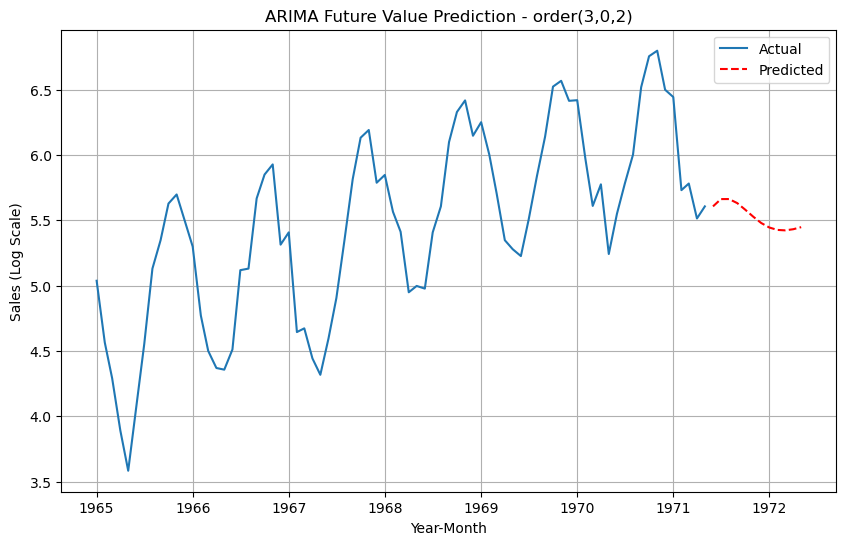

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

model = sm.tsa.ARIMA(ts_log, order=(3, 0, 2))
results_ARIMA = model.fit() 

try:
    ts_predict = results_ARIMA.predict('1971-06-01', '1972-05-01')
except KeyError:
    ts_predict = results_ARIMA.forecast(steps=12)

plt.figure(figsize=(10, 6))
plt.title('ARIMA Future Value Prediction - order(3,0,2)')

plt.plot(ts_log, label='Actual')

plt.plot(ts_predict, 'r--', label='Predicted')

plt.xlabel('Year-Month')
plt.ylabel('Sales (Log Scale)')
plt.legend(loc='best')
plt.grid(True)
plt.show()